* https://www.kaggle.com/datasets/andrewmvd/road-sign-detection/data

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 874.8/874.8 kB 15.8 MB/s eta 0:00:00


In [ ]:
import os
import random
import shutil
import cv2
import glob
import yaml
import matplotlib.pyplot as plt
import ultralytics
import numpy as np
import torch
import xml.etree.ElementTree as ET
from torchvision import transforms
from tqdm import tqdm
from PIL import Image
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
! kaggle datasets download -d andrewmvd/road-sign-detection

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/road-sign-detection
License(s): CC0-1.0
100% 218M/218M [00:16<00:00, 17.9MB/s]
100% 218M/218M [00:16<00:00, 14.3MB/s]


In [ ]:
!unzip -q /content/road-sign-detection.zip

In [ ]:
# road_sign_detection 디렉토리 생성
data_root = '/content/road_sign_detection'
# road_sign_detection/data 디렉토리 생성
file_root = f'{data_root}/data'
project_name = 'rsd'

train_root = f'{data_root}/{project_name}/train'
valid_root = f'{data_root}/{project_name}/valid'
test_root = f'{data_root}/{project_name}/test'

In [ ]:
for folder in [train_root, valid_root, test_root]:
    if not os.path.exists(folder):
        os.makedirs(folder)
    for s in ['images', 'labels']:
        s_folder = f'{folder}/{s}'
        if not os.path.exists(s_folder):
            os.makedirs(s_folder)

In [ ]:
# road_sign_detection/data 디렉토리에 images, annotations를 넣어줌
file_list = glob.glob(f'{file_root}/images/*.png')
len(file_list)

877

In [ ]:
def xml_to_yolo_bbox(bbox, w, h):
    x_center = ((bbox[2] + bbox[0]) / 2) / w
    y_center = ((bbox[3] + bbox[1]) / 2) / h
    width = (bbox[2] - bbox[0]) / w
    height = (bbox[3] - bbox[1]) / h
    return [x_center, y_center, width, height]

In [ ]:
# /content/road_sign_detection/data/labels 디렉토리 생성

classes = []
for file in tqdm(file_list):
    file_name = file.split('/')[-1].replace('png', 'xml')
    save_name = file_name.replace('xml', 'txt')
    file_path = f'{file_root}/annotations/{file_name}'
    save_path = f'{file_root}/labels/{save_name}'

    result = list()
    tree = ET.parse(file_path)
    root = tree.getroot()
    width = int(root.find('size').find('width').text)
    height = int(root.find('size').find('height').text)
    for obj in root.findall('object'):
        label = obj.find('name').text
        if label not in classes:
            classes.append(label)
        index = classes.index(label)
        pil_bbox = [int(x.text) for x in obj.find('bndbox')]
        yolo_bbox = xml_to_yolo_bbox(pil_bbox, width, height)
        bbox_string = ' '.join([str(x) for x in yolo_bbox])
        result.append(f'{index} {bbox_string}')
    if result:
        with open(save_path, 'w', encoding='utf-8') as f:
            f.write('\n'.join(result))

100%|██████████| 877/877 [00:00<00:00, 6928.22it/s]


In [ ]:
print(classes)

['speedlimit', 'trafficlight', 'crosswalk', 'stop']


In [ ]:
cls_list = ['speedlimit', 'crosswalk', 'trafficlight', 'stop']

In [ ]:
random.seed(2024)

In [ ]:
random.shuffle(file_list)
test_ratio = 0.1
num_file = len(file_list)

test_list = file_list[:int(num_file*test_ratio)]
valid_list = file_list[int(num_file*test_ratio):int(num_file*test_ratio)*2]
train_list = file_list[int(num_file*test_ratio)*2:]

In [ ]:
for i in test_list:
    label_name = i.split('/')[-1].replace('png', 'txt')
    label_path = f'{file_root}/labels/{label_name}'
    shutil.copyfile(label_path, f'{test_root}/labels/{label_name}')
    img_name = i.split('/')[-1]
    shutil.copyfile(i, f'{test_root}/images/{img_name}')

for i in valid_list:
    label_name = i.split('/')[-1].replace('png', 'txt')
    label_path = f'{file_root}/labels/{label_name}'
    shutil.copyfile(label_path, f'{valid_root}/labels/{label_name}')
    img_name = i.split('/')[-1]
    shutil.copyfile(i, f'{valid_root}/images/{img_name}')

for i in train_list:
    label_name = i.split('/')[-1].replace('png', 'txt')
    label_path = f'{file_root}/labels/{label_name}'
    shutil.copyfile(label_path, f'{train_root}/labels/{label_name}')
    img_name = i.split('/')[-1]
    shutil.copyfile(i, f'{train_root}/images/{img_name}')

In [ ]:
pjt_root = '/content/road_sign_detection'

In [ ]:
%cd /content/road_sign_detection

/content/road_sign_detection


In [ ]:
data = dict()

data['train'] = train_root
data['val'] = valid_root
data['test'] = test_root
data['nc'] = len(cls_list)
data['names'] = cls_list

with open(f'{pjt_root}/road_sign.yaml', 'w') as f:
    yaml.dump(data, f)

In [ ]:
%cd /content/road_sign_detection

/content/road_sign_detection


In [ ]:
model = YOLO('yolov8s.pt')
# amp=False: 연산 성능을 최적화하기 위해 fp16(False), fp32(True) 중 선택
results = model.train(data='road_sign.yaml', epochs=100, batch=8, imgsz=224, device=0, workers=4, amp=False, patience=30, name='road_sign_s')

Ultralytics YOLOv8.2.102 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=road_sign.yaml, epochs=100, time=None, patience=30, batch=8, imgsz=224, save=True, save_period=-1, cache=False, device=0, workers=4, project=None, name=road_sign_s3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=T

train: Scanning /content/road_sign_detection/rsd/train/labels.cache... 703 images, 0 backgrounds, 0 corrupt: 100%|██████████| 703/703 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/road_sign_detection/rsd/valid/labels.cache... 87 images, 0 backgrounds, 0 corrupt: 100%|██████████| 87/87 [00:00<?, ?it/s]


Plotting labels to runs/detect/road_sign_s3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/detect/road_sign_s3
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.12G     0.8713      1.437     0.9313         22        224: 100%|██████████| 88/88 [00:16<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.84it/s]


                   all         87        121      0.869      0.606       0.68      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      0.81G     0.8818      0.861     0.9381         16        224: 100%|██████████| 88/88 [00:13<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.74it/s]

                   all         87        121      0.632      0.603      0.633      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100     0.791G     0.9138     0.8295     0.9423         17        224: 100%|██████████| 88/88 [00:10<00:00,  8.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.59it/s]

                   all         87        121      0.939      0.531      0.647      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100     0.784G     0.8845     0.7621      0.947         21        224: 100%|██████████| 88/88 [00:10<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.49it/s]

                   all         87        121      0.743      0.636      0.661      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100     0.784G     0.8389     0.6845     0.9427         18        224: 100%|██████████| 88/88 [00:12<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.44it/s]

                   all         87        121       0.88      0.629      0.725      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100     0.763G     0.8427     0.6827     0.9557         17        224: 100%|██████████| 88/88 [00:12<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.14it/s]

                   all         87        121       0.79      0.659      0.704      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100     0.784G     0.8511     0.6616     0.9362         24        224: 100%|██████████| 88/88 [00:09<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.95it/s]

                   all         87        121      0.775      0.662      0.659      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100     0.784G     0.7931     0.6149     0.9206         12        224: 100%|██████████| 88/88 [00:13<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.01it/s]

                   all         87        121      0.809      0.634       0.69      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100     0.784G     0.7828     0.5955     0.9284         11        224: 100%|██████████| 88/88 [00:12<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.24it/s]

                   all         87        121      0.878      0.645      0.748      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100     0.784G     0.7688     0.5674     0.9015         19        224: 100%|██████████| 88/88 [00:09<00:00,  9.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.93it/s]

                   all         87        121      0.883      0.707      0.774      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100     0.784G     0.7676     0.5777     0.9215         10        224: 100%|██████████| 88/88 [00:11<00:00,  7.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.29it/s]

                   all         87        121      0.816      0.751      0.755      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100     0.784G     0.7577     0.5772     0.9088         23        224: 100%|██████████| 88/88 [00:13<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.31it/s]

                   all         87        121      0.802      0.674      0.708      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100     0.784G     0.7681     0.5791     0.9189         18        224: 100%|██████████| 88/88 [00:10<00:00,  8.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.52it/s]


                   all         87        121      0.843      0.632      0.718      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100     0.782G     0.7475     0.5564     0.8945         23        224: 100%|██████████| 88/88 [00:10<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.75it/s]


                   all         87        121      0.874      0.674      0.762      0.591

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100     0.782G     0.7262     0.5182     0.9007         17        224: 100%|██████████| 88/88 [00:13<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.37it/s]

                   all         87        121      0.876      0.679      0.746      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100     0.782G     0.7522     0.5202     0.8976          9        224: 100%|██████████| 88/88 [00:13<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.92it/s]

                   all         87        121      0.856      0.714      0.763      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100     0.782G      0.709     0.5019     0.8833         15        224: 100%|██████████| 88/88 [00:09<00:00,  9.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]

                   all         87        121      0.915      0.665      0.774      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100     0.782G     0.7066     0.4872     0.8859         12        224: 100%|██████████| 88/88 [00:13<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.01it/s]

                   all         87        121      0.851       0.75      0.795      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100     0.782G     0.7147     0.5003     0.8952         24        224: 100%|██████████| 88/88 [00:13<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 10.04it/s]

                   all         87        121      0.954      0.709      0.817      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100     0.782G     0.6852        0.5     0.8851         11        224: 100%|██████████| 88/88 [00:10<00:00,  8.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.37it/s]


                   all         87        121      0.861      0.705      0.778      0.575

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100     0.782G      0.706       0.51     0.8746         20        224: 100%|██████████| 88/88 [00:10<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.19it/s]

                   all         87        121       0.85      0.661      0.713      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100     0.782G     0.6705     0.4748     0.8728          9        224: 100%|██████████| 88/88 [00:13<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.32it/s]

                   all         87        121      0.906       0.71      0.803      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100     0.782G     0.7059     0.5011     0.8792         23        224: 100%|██████████| 88/88 [00:12<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.84it/s]

                   all         87        121       0.86      0.711      0.762      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100     0.782G     0.6697     0.4552     0.8872         14        224: 100%|██████████| 88/88 [00:09<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.54it/s]

                   all         87        121      0.901      0.714      0.783      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100     0.782G     0.6758     0.4667      0.886         17        224: 100%|██████████| 88/88 [00:13<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.94it/s]

                   all         87        121      0.821      0.749      0.731      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100     0.782G      0.663     0.4652     0.8844         26        224: 100%|██████████| 88/88 [00:14<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.55it/s]

                   all         87        121      0.838      0.727      0.771      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100     0.782G      0.698     0.4685     0.8771         13        224: 100%|██████████| 88/88 [00:10<00:00,  8.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.71it/s]

                   all         87        121      0.863      0.767      0.796      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100     0.782G     0.6736     0.4493     0.8707         30        224: 100%|██████████| 88/88 [00:10<00:00,  8.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.42it/s]

                   all         87        121      0.825      0.722      0.773      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100     0.782G     0.6582      0.449     0.8754         14        224: 100%|██████████| 88/88 [00:13<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.50it/s]

                   all         87        121       0.92      0.714      0.819      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100     0.782G     0.6516     0.4498     0.8645         26        224: 100%|██████████| 88/88 [00:13<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.45it/s]

                   all         87        121      0.854      0.765      0.836       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100     0.782G     0.6419     0.4443     0.8655         12        224: 100%|██████████| 88/88 [00:09<00:00,  9.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.22it/s]

                   all         87        121      0.813       0.81      0.843      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100     0.782G     0.6372     0.4294     0.8702         21        224: 100%|██████████| 88/88 [00:12<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.78it/s]

                   all         87        121      0.924      0.796      0.836      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100     0.782G     0.6626     0.4348      0.874         24        224: 100%|██████████| 88/88 [00:13<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.82it/s]

                   all         87        121      0.877      0.733      0.833       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100     0.782G     0.6275     0.4233      0.861         20        224: 100%|██████████| 88/88 [00:11<00:00,  7.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.68it/s]

                   all         87        121      0.794      0.742      0.791      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100     0.782G     0.6274     0.4098     0.8704         22        224: 100%|██████████| 88/88 [00:10<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.22it/s]

                   all         87        121      0.827      0.773        0.8      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100     0.782G     0.6309     0.4191     0.8653         17        224: 100%|██████████| 88/88 [00:13<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.19it/s]

                   all         87        121        0.8      0.798      0.798      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100     0.782G     0.6392     0.4294     0.8605         17        224: 100%|██████████| 88/88 [00:11<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.27it/s]

                   all         87        121      0.846      0.793      0.826      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100     0.782G     0.6313     0.4366     0.8746         25        224: 100%|██████████| 88/88 [00:09<00:00,  9.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.94it/s]

                   all         87        121      0.855      0.789      0.806      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100     0.782G     0.6331     0.4186     0.8616         21        224: 100%|██████████| 88/88 [00:13<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.63it/s]

                   all         87        121      0.828      0.749      0.784      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100     0.782G     0.6461     0.4281     0.8713         15        224: 100%|██████████| 88/88 [00:13<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.32it/s]

                   all         87        121      0.876      0.754      0.778      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100     0.782G     0.6067     0.4111     0.8532         13        224: 100%|██████████| 88/88 [00:09<00:00,  8.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.27it/s]

                   all         87        121      0.805      0.808        0.8      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100     0.782G     0.6214     0.4086     0.8561         27        224: 100%|██████████| 88/88 [00:11<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.18it/s]

                   all         87        121      0.875      0.806      0.826       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100     0.782G     0.6214     0.4086     0.8642         25        224: 100%|██████████| 88/88 [00:13<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.50it/s]

                   all         87        121       0.73      0.825      0.769      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100     0.782G     0.5863     0.3867     0.8567         14        224: 100%|██████████| 88/88 [00:11<00:00,  7.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.31it/s]

                   all         87        121      0.842      0.737      0.815      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100     0.782G     0.5834     0.3939     0.8452         12        224: 100%|██████████| 88/88 [00:10<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.31it/s]

                   all         87        121      0.851      0.803      0.828       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100     0.782G     0.6048     0.3838      0.862         14        224: 100%|██████████| 88/88 [00:13<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.29it/s]

                   all         87        121      0.824       0.81      0.817      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100     0.782G     0.5865     0.3871     0.8531         19        224: 100%|██████████| 88/88 [00:12<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.22it/s]

                   all         87        121      0.846      0.817      0.818      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100     0.782G     0.5958     0.3791     0.8498         13        224: 100%|██████████| 88/88 [00:09<00:00,  9.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.45it/s]

                   all         87        121      0.832      0.829      0.817      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100     0.782G     0.5989      0.382     0.8483         10        224: 100%|██████████| 88/88 [00:13<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.76it/s]

                   all         87        121      0.845      0.743       0.81      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100     0.782G      0.586     0.3822     0.8529         25        224: 100%|██████████| 88/88 [00:12<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.72it/s]

                   all         87        121      0.887      0.828      0.843      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100     0.782G     0.5872     0.3927     0.8532         23        224: 100%|██████████| 88/88 [00:10<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.03it/s]


                   all         87        121      0.873      0.811      0.832      0.648

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100     0.782G     0.5756     0.3886     0.8535         18        224: 100%|██████████| 88/88 [00:11<00:00,  7.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.19it/s]

                   all         87        121      0.873      0.803      0.831      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100     0.782G     0.5808     0.3769     0.8564         23        224: 100%|██████████| 88/88 [00:12<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.79it/s]

                   all         87        121      0.836       0.82      0.815      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100     0.782G     0.5773     0.3702     0.8494         15        224: 100%|██████████| 88/88 [00:11<00:00,  7.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.44it/s]


                   all         87        121      0.896       0.83      0.845      0.676

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100     0.782G     0.5748     0.3593     0.8565         22        224: 100%|██████████| 88/88 [00:09<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.13it/s]

                   all         87        121      0.891      0.791      0.842      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100     0.782G     0.5747     0.3655     0.8502         29        224: 100%|██████████| 88/88 [00:13<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.19it/s]

                   all         87        121      0.878      0.837      0.843      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100     0.782G      0.576     0.3661     0.8547         26        224: 100%|██████████| 88/88 [00:12<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.71it/s]

                   all         87        121      0.907      0.771      0.841      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100     0.782G      0.552     0.3627     0.8429         15        224: 100%|██████████| 88/88 [00:09<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


                   all         87        121      0.832      0.833      0.827      0.655

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100     0.782G     0.5551     0.3556     0.8445         24        224: 100%|██████████| 88/88 [00:12<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.77it/s]

                   all         87        121      0.848      0.809      0.814      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100     0.782G     0.5691     0.3594     0.8441         13        224: 100%|██████████| 88/88 [00:13<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.74it/s]

                   all         87        121      0.869      0.825      0.827      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100     0.782G     0.5693     0.3673     0.8512         29        224: 100%|██████████| 88/88 [00:10<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.47it/s]


                   all         87        121      0.828      0.833      0.821      0.676

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100     0.782G      0.567     0.3642     0.8405         19        224: 100%|██████████| 88/88 [00:11<00:00,  7.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.65it/s]

                   all         87        121      0.875      0.797      0.837      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100     0.782G     0.5502     0.3511     0.8426         11        224: 100%|██████████| 88/88 [00:13<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.49it/s]

                   all         87        121      0.852      0.825       0.82      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100     0.782G     0.5515      0.347     0.8494         19        224: 100%|██████████| 88/88 [00:12<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.35it/s]


                   all         87        121      0.849      0.831      0.848       0.66

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100     0.782G     0.5512     0.3487     0.8473         17        224: 100%|██████████| 88/88 [00:09<00:00,  9.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.11it/s]

                   all         87        121      0.885      0.791      0.843      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100     0.782G     0.5214     0.3387     0.8384         34        224: 100%|██████████| 88/88 [00:13<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.57it/s]

                   all         87        121      0.893       0.78      0.835      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100     0.782G     0.5329     0.3326     0.8372         25        224: 100%|██████████| 88/88 [00:12<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.67it/s]

                   all         87        121       0.89      0.827      0.827      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100     0.782G     0.5491     0.3448     0.8392         21        224: 100%|██████████| 88/88 [00:09<00:00,  8.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.64it/s]

                   all         87        121      0.872      0.812      0.829      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100     0.782G     0.5192     0.3293      0.829         21        224: 100%|██████████| 88/88 [00:11<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.96it/s]

                   all         87        121      0.848      0.821      0.849      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100     0.782G     0.5186     0.3247      0.838         19        224: 100%|██████████| 88/88 [00:13<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.35it/s]

                   all         87        121      0.916      0.836      0.847      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100     0.782G     0.5461     0.3327     0.8379         17        224: 100%|██████████| 88/88 [00:10<00:00,  8.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.13it/s]

                   all         87        121      0.898        0.8      0.833      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100     0.782G     0.5195      0.331     0.8328         18        224: 100%|██████████| 88/88 [00:09<00:00,  9.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.17it/s]

                   all         87        121      0.915      0.813      0.842      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100     0.782G     0.5135     0.3258     0.8356         23        224: 100%|██████████| 88/88 [00:13<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.75it/s]

                   all         87        121      0.864      0.837      0.836      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100     0.782G     0.5185     0.3242     0.8377         18        224: 100%|██████████| 88/88 [00:13<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.19it/s]

                   all         87        121       0.88      0.816      0.843      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100     0.782G     0.5224     0.3344     0.8451         18        224: 100%|██████████| 88/88 [00:09<00:00,  9.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.28it/s]


                   all         87        121      0.859      0.818      0.837      0.673

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100     0.782G     0.5134     0.3128     0.8291         15        224: 100%|██████████| 88/88 [00:12<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.51it/s]

                   all         87        121      0.858      0.821       0.83      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100     0.782G     0.5055     0.3212     0.8487         31        224: 100%|██████████| 88/88 [00:13<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.07it/s]

                   all         87        121      0.857      0.842      0.838      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100     0.782G     0.5018     0.3217     0.8318         15        224: 100%|██████████| 88/88 [00:10<00:00,  8.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.32it/s]

                   all         87        121      0.863      0.821      0.831      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100     0.782G     0.5031     0.3111     0.8381         14        224: 100%|██████████| 88/88 [00:11<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.14it/s]

                   all         87        121      0.858       0.83      0.849      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100     0.782G     0.5213     0.3234     0.8338         21        224: 100%|██████████| 88/88 [00:13<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.97it/s]

                   all         87        121       0.87      0.795      0.846       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100     0.782G     0.4979     0.3084     0.8327         22        224: 100%|██████████| 88/88 [00:11<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.78it/s]

                   all         87        121      0.894      0.821      0.843      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100     0.782G     0.4897     0.3007     0.8362         11        224: 100%|██████████| 88/88 [00:09<00:00,  9.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.36it/s]

                   all         87        121        0.9      0.813      0.847      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100     0.782G     0.5128     0.3184     0.8391         27        224: 100%|██████████| 88/88 [00:12<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.75it/s]

                   all         87        121      0.883      0.776      0.841      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100     0.782G     0.4884     0.3038     0.8301         15        224: 100%|██████████| 88/88 [00:13<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.75it/s]


                   all         87        121      0.922      0.736      0.835      0.693

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100     0.782G     0.4853     0.3032     0.8383         21        224: 100%|██████████| 88/88 [00:10<00:00,  8.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.83it/s]

                   all         87        121      0.903      0.754      0.835      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100     0.782G     0.5107     0.3205     0.8367         18        224: 100%|██████████| 88/88 [00:11<00:00,  7.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.12it/s]

                   all         87        121      0.865      0.837      0.852      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100     0.782G     0.4872     0.2981     0.8342         15        224: 100%|██████████| 88/88 [00:12<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.04it/s]

                   all         87        121      0.911       0.83      0.859      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100     0.782G     0.5069     0.3005     0.8271         13        224: 100%|██████████| 88/88 [00:12<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.84it/s]

                   all         87        121      0.917      0.825      0.863      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100     0.782G     0.4848     0.2955     0.8348         16        224: 100%|██████████| 88/88 [00:09<00:00,  9.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.49it/s]

                   all         87        121      0.921      0.818      0.856      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100     0.782G     0.4869     0.3058     0.8249         15        224: 100%|██████████| 88/88 [00:12<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.17it/s]

                   all         87        121      0.929      0.807      0.858      0.707


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100     0.782G     0.5083      0.274     0.8075         10        224: 100%|██████████| 88/88 [00:13<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.54it/s]

                   all         87        121      0.919      0.805      0.841      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100     0.782G     0.4756     0.2686      0.796         10        224: 100%|██████████| 88/88 [00:11<00:00,  7.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.71it/s]

                   all         87        121      0.921      0.783      0.842        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100     0.782G     0.4722     0.2652     0.8023         10        224: 100%|██████████| 88/88 [00:09<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.98it/s]

                   all         87        121      0.921      0.824      0.854      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100     0.782G     0.4755     0.2665     0.7945         13        224: 100%|██████████| 88/88 [00:12<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.72it/s]

                   all         87        121      0.925      0.824      0.853      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100     0.782G     0.4659      0.264     0.8024         11        224: 100%|██████████| 88/88 [00:12<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.79it/s]

                   all         87        121      0.902      0.824       0.85      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100     0.782G     0.4597     0.2613     0.7911          7        224: 100%|██████████| 88/88 [00:09<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.99it/s]

                   all         87        121      0.922      0.825      0.853        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100     0.782G     0.4615     0.2557     0.8031          9        224: 100%|██████████| 88/88 [00:12<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.23it/s]

                   all         87        121      0.897      0.809      0.854      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100     0.782G     0.4539     0.2515     0.7979          9        224: 100%|██████████| 88/88 [00:13<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.63it/s]

                   all         87        121      0.884      0.833      0.854      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100     0.782G     0.4524     0.2539     0.7955         11        224: 100%|██████████| 88/88 [00:09<00:00,  9.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.06it/s]

                   all         87        121      0.923      0.784      0.856      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100     0.782G     0.4506     0.2508     0.8043          8        224: 100%|██████████| 88/88 [00:11<00:00,  7.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.42it/s]

                   all         87        121      0.835      0.834      0.853       0.71



100 epochs completed in 0.388 hours.
Optimizer stripped from runs/detect/road_sign_s3/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/road_sign_s3/weights/best.pt, 22.5MB

Validating runs/detect/road_sign_s3/weights/best.pt...
Ultralytics YOLOv8.2.102 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.96it/s]


                   all         87        121      0.923      0.784      0.856      0.711
            speedlimit         66         73      0.984      0.973      0.994      0.909
             crosswalk         10         14      0.824      0.671      0.681       0.55
          trafficlight         19         27      0.909      0.778        0.9      0.643
                  stop          7          7      0.977      0.714      0.849      0.744
Speed: 0.3ms preprocess, 2.4ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/road_sign_s3


In [ ]:
%cd /content/road_sign_detection

/content/road_sign_detection


In [ ]:
result_folder = f'{pjt_root}/runs/detect'

In [ ]:
model = YOLO(f'{result_folder}/road_sign_s3/weights/best.pt')
metrics = model.val(split='test')
print('mAP50-95', metrics.box.map)
print('mAP50', metrics.box.map50)

Ultralytics YOLOv8.2.102 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /content/road_sign_detection/rsd/test/labels.cache... 87 images, 0 backgrounds, 0 corrupt: 100%|██████████| 87/87 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.47it/s]


                   all         87        111      0.892      0.864      0.877      0.752
            speedlimit         63         71      0.993      0.958       0.98      0.887
             crosswalk         11         16      0.655        0.5      0.538      0.343
          trafficlight         10         12      0.956          1      0.995      0.837
                  stop         12         12      0.966          1      0.995      0.939
Speed: 0.1ms preprocess, 3.3ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/val2
mAP50-95 0.7515500513405369
mAP50 0.8768713764535608


In [ ]:
%cd /content/road_sign_detection

/content/road_sign_detection


In [ ]:
result_folder = f'{pjt_root}/runs/detect/road_sign_s3'
pjt_name = 'rsd'
test_root = f'{data_root}/{pjt_name}/test'

test_file_list = glob.glob(f'{test_root}/images/*')
random.shuffle(test_file_list)

In [ ]:
model = YOLO(f'{result_folder}/weights/best.pt')

test_data_transform = transforms.Compose([
    transforms.ToTensor()
])

color_dict = [[random.randint(0, 255) for _ in range(3)] for _ in range(0, len(model.names))]

In [ ]:
test_img = cv2.imread(test_file_list[0])
img_src = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
results = model(img_src)


0: 224x192 1 speedlimit, 10.9ms
Speed: 1.0ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 224, 192)


In [ ]:
print(result[0].boxes)

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.], device='cuda:0')
conf: tensor([0.9341], device='cuda:0')
data: tensor([[ 94.5537, 162.4943, 176.8606, 245.8947,   0.9341,   0.0000]], device='cuda:0')
id: None
is_track: False
orig_shape: (400, 300)
shape: torch.Size([1, 6])
xywh: tensor([[135.7071, 204.1945,  82.3069,  83.4005]], device='cuda:0')
xywhn: tensor([[0.4524, 0.5105, 0.2744, 0.2085]], device='cuda:0')
xyxy: tensor([[ 94.5537, 162.4943, 176.8606, 245.8947]], device='cuda:0')
xyxyn: tensor([[0.3152, 0.4062, 0.5895, 0.6147]], device='cuda:0')



0: 224x192 1 speedlimit, 23.9ms
Speed: 1.2ms preprocess, 23.9ms inference, 2.7ms postprocess per image at shape (1, 3, 224, 192)


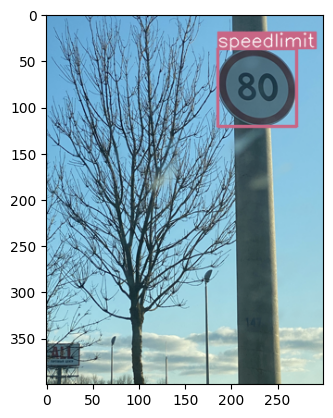

In [ ]:
test_img = cv2.imread(test_file_list[0])
img_src = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
result = model(img_src)[0]

annotator = Annotator(img_src)
boxes = result.boxes
for box in boxes:
    b = box.xyxy[0]
    cls = box.cls
    annotator.box_label(b, model.names[int(cls)], tuple(color_dict[int(cls)]))
img_src = annotator.result()
plt.imshow(img_src)
plt.show()


0: 224x192 1 speedlimit, 26.0ms
Speed: 1.2ms preprocess, 26.0ms inference, 3.6ms postprocess per image at shape (1, 3, 224, 192)

0: 224x160 2 crosswalks, 22.1ms
Speed: 1.0ms preprocess, 22.1ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 160)

0: 224x192 1 speedlimit, 20.4ms
Speed: 3.4ms preprocess, 20.4ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 192)

0: 224x192 1 speedlimit, 13.9ms
Speed: 0.9ms preprocess, 13.9ms inference, 2.3ms postprocess per image at shape (1, 3, 224, 192)

0: 224x192 1 speedlimit, 14.7ms
Speed: 1.0ms preprocess, 14.7ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 192)

0: 224x192 1 speedlimit, 22.5ms
Speed: 1.1ms preprocess, 22.5ms inference, 9.9ms postprocess per image at shape (1, 3, 224, 192)


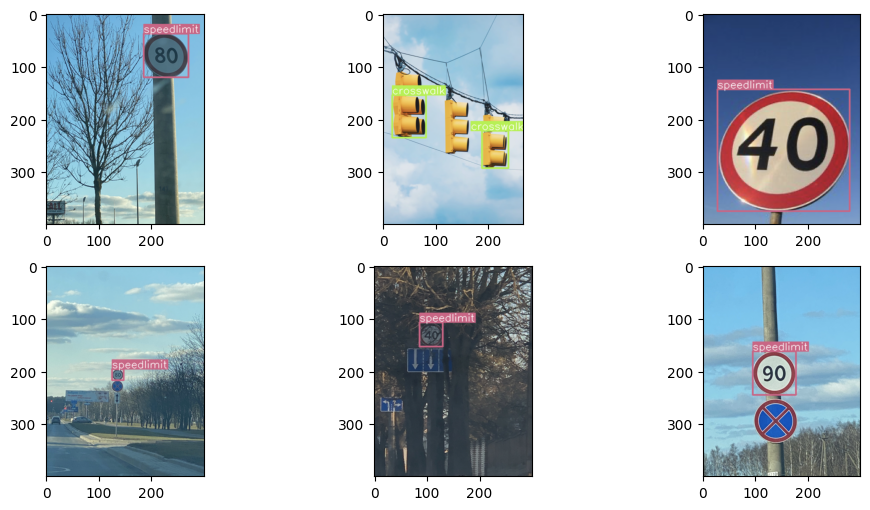

In [ ]:
plt.figure(figsize = (12,6))
for idx in range(6):
    test_img = cv2.imread(test_file_list[idx])
    img_src = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    results = model(test_img)

    for result in results:
        annotator = Annotator(img_src)
        boxes = result.boxes
        for box in boxes:
            b = box.xyxy[0]
            cls = box.cls
            annotator.box_label(b, model.names[int(cls)], tuple(color_dict[int(cls)]))
    img_src = annotator.result()

    plt.subplot(2, 3, (idx+1))
    plt.imshow(img_src)
plt.show()